# Project 50: Galaxy classification
## Author: Ainhoa Serrano

# Objectives
### The goal of the project is the application Neural Networks for Galaxy classification, which consists of, given an image, predict the probability that it belongs in a particular galaxy class (generally determined by its morphology).

### Tasks done: Importing the libraries, organization of the data in folders for the following tasks, creation of a dataframe, augmentation of data, definition of the models, training of the models, validation of the models. 

# Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import shutil

import keras
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, GlobalAveragePooling2D,BatchNormalization
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.models import model_from_yaml
from keras.optimizers import Adam
from keras.datasets import mnist, fashion_mnist, boston_housing
from keras import regularizers 
import keras.backend as K
from PIL import Image
import tensorflow as tf
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.models import load_model

#Since I have used Google Colab to code and test my implementation, I have defined my drive path
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
PATHGZ = "drive/My Drive/Colab Notebooks/Galaxy_zoo/"

Mounted at /content/drive


Create the images path

Since the data was in the same folder and I need one folder for each training, validation and test data, the following cells create a variable for each name and a folder for each one.

In [ ]:
images_path = PATHGZ+"images/"
train_path = images_path+"train/"
val_path = images_path+"val/"
test_path = images_path+"test/"

if not (os.path.exists(images_path)):
  os.mkdir(images_path)

Split the images into 3 folders: train, validation and test. These cells create the needed folders and copy the needed images in the defined working space, in this case, in my Drive.

In [ ]:
#Create train path -- first 8000 images
if not (os.path.exists(train_path)):
  os.mkdir(train_path)
  for i in range(8):
    path = PATHGZ+'images_train_small_'+str(i)+'/'
    imgpathS = os.listdir(path)
    for f in imgpathS:
        shutil.copy(path+f,train_path)

In [ ]:
#Create validation path -- following 2000 images
if not (os.path.exists(val_path)):
  os.mkdir(val_path)
  for i in [8,9]:
    path = PATHGZ+'images_train_small_'+str(i)+'/'
    imgpathS = os.listdir(path)
    for f in imgpathS:
        shutil.copy(path+f,val_path)

In [ ]:
#Create test path -- following 2000 images
if not (os.path.exists(test_path)):
  os.mkdir(test_path)
  for i in [10,11]:
    path = PATHGZ+'images_train_small_'+str(i)+'/'
    imgpathS = os.listdir(path)
    for f in imgpathS:
        shutil.copy(path+f,test_path)

## 1.Read the data

In the following cell, I take the first 12000 instances of the data. The file with the training solutions is read and then a dataframe is created with the 12000 instances.

In [ ]:
filepath = PATHGZ+"training_solutions_rev1.csv"
#Dataframe containing the image ids in the first column and the images values for the 37 classes in the following columns
df = pd.read_csv(filepath)
dfSmall = df.head(12000)  #Dataframe of the first 12000 instances

#Append .jpg to all ids so that it matches the filenames of the images
def append_ext(fn):
    return str(fn)+".jpg"


dfSmall["GalaxyID"]=dfSmall["GalaxyID"].apply(append_ext)

print(dfSmall.iloc[:10])
print(dfSmall.shape)

     GalaxyID  Class1.1  Class1.2  ...  Class11.4  Class11.5  Class11.6
0  100008.jpg  0.383147  0.616853  ...   0.000000   0.000000   0.325512
1  100023.jpg  0.327001  0.663777  ...   0.000000   0.000000   0.000000
2  100053.jpg  0.765717  0.177352  ...   0.000000   0.000000   0.000000
3  100078.jpg  0.693377  0.238564  ...   0.000000   0.000000   0.000000
4  100090.jpg  0.933839  0.000000  ...   0.000000   0.000000   0.000000
5  100122.jpg  0.738832  0.238159  ...   0.000000   0.000000   0.000000
6  100123.jpg  0.462492  0.456033  ...   0.000000   0.000000   0.000000
7  100128.jpg  0.687783  0.288344  ...   0.000000   0.000000   0.000000
8  100134.jpg  0.021834  0.976952  ...   0.081974   0.081974   0.327894
9  100143.jpg  0.269843  0.730157  ...   0.000000   0.000000   0.000000

[10 rows x 38 columns]
(12000, 38)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Here I split the dataframe into train, validation and test

In [ ]:
df_train = dfSmall.iloc[:8000,:]      #Training dataset
df_val = dfSmall.iloc[8000:10000,:]   #Validation dataset
df_test = dfSmall.iloc[10000:,:]      #Test dataset

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(8000, 38)
(2000, 38)
(2000, 38)


The following cell creates an array with the name of the 37 classes so that it can be passed to the generators created in the following section.

In [ ]:
# Get ndArray of column names of the classes
columnsNamesArr = dfSmall.columns.values[1:]
# convert ndarray to list
col_names = list(columnsNamesArr)
print(col_names)

['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4', 'Class11.5', 'Class11.6']


## 2. Preprocess the images

### Create the generators

Now the generators need to be created. These are used so that the keras models can be trained. The generators take a path to the data and generate batches of tensor image data that the model can use as the data will be looped over (in batches). This generators can be used to create augmented data.

In [ ]:
# Note that the validation data should not be augmented!
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)


It has to be taken into account that only the training data can be augmented, the validation data shouldn't be.

### First generators

The train and validation generators take the images from the train_path and the validation_path respectively and the target values from the train and validation datasets. These generators resize the data to the target_size value, because the original data images are (424,424) which is too high, so in order to reduce the training time the images are reescaled

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train, directory=train_path,
                                             x_col='GalaxyID',
                                             y_col=col_names,
                                             target_size=(100,100),
                                             class_mode='raw',
                                             batch_size=100,
                                             seed=7)
 
validation_generator = val_datagen.flow_from_dataframe(dataframe=df_val, directory=val_path,
                                             x_col='GalaxyID',
                                             y_col=col_names,
                                             target_size=(100,100),
                                             class_mode='raw',
                                             batch_size=100,
                                             seed=7)


Found 8000 validated image filenames.
Found 2000 validated image filenames.


### Visualization of some of the images of the generators

As it can be observed, the train_generators images are distorted in comparison to the validation_generator images, that happens because of the augmentation that was only used in the training generator.

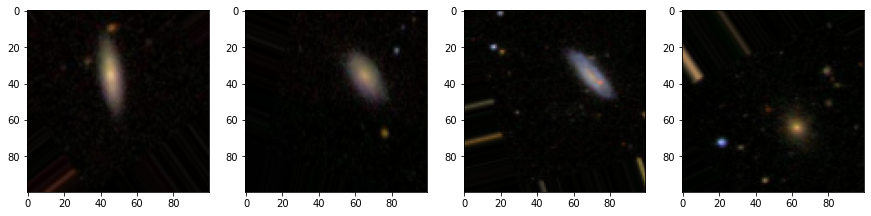

In [ ]:
x,y = train_generator.next()
f, axarr = plt.subplots(1,4, figsize=(15, 15))
axarr[0].imshow(x[0])
axarr[1].imshow(x[1])
axarr[2].imshow(x[2])
axarr[3].imshow(x[3])

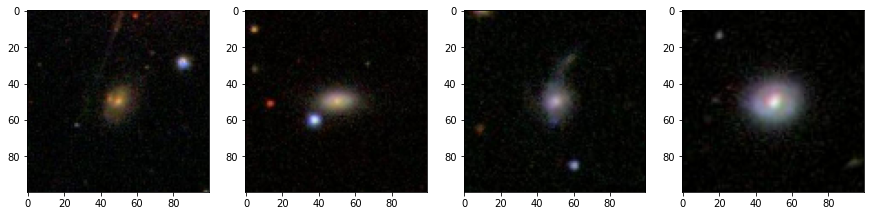

In [ ]:
x,y = validation_generator.next()
f, axarr = plt.subplots(1,4, figsize=(15, 15))
axarr[0].imshow(x[0])
axarr[1].imshow(x[1])
axarr[2].imshow(x[2])
axarr[3].imshow(x[3])

### Second generators. These use cropping in the training data, and as the keras implementation doesn't have a crop option, it is custom made

In the following cell, I define 2 methods. The method center_crop takes an image, crops it and then resizes it to the desired size. The crop_generator method is used so that the previously created generators remain the same. This calls the center crop method for each image.

In [ ]:
#This makes a cropping that takes the center of the images, so it crops the same space from each border
def center_crop(img, crop_size, new_size):
    height, width = img.shape[0], img.shape[1]
    dy, dx = crop_size
    x = (width - dx + 1) // 2
    y = (height - dy + 1) // 2
    img=img[y:(y+dy), x:(x+dx), :]
    img=resize(img, new_size)
    return img

#This creates a generator with the cropped images that then it will be fed to the model.
def crop_generator(batches, crop_size, new_size):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], new_size, new_size, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = center_crop(batch_x[i], (crop_size, crop_size), (new_size,new_size))
        yield (batch_crops, batch_y)


In [ ]:
# Second generators, this ones are to be used with the cropping method
train_generator2 = train_datagen.flow_from_dataframe(dataframe=df_train, directory=train_path,
                                             x_col='GalaxyID',
                                             y_col=col_names,
                                             class_mode='raw',
                                             batch_size=100,
                                             seed=7)
 
validation_generator2 = val_datagen.flow_from_dataframe(dataframe=df_val, directory=val_path,
                                             x_col='GalaxyID',
                                             y_col=col_names,
                                             class_mode='raw',
                                             batch_size=100,
                                             target_size=(70,70),
                                             seed=7)


Found 8000 validated image filenames.
Found 2000 validated image filenames.


In [ ]:
CROP_SIZE = 250
NEW_SIZE = 70

#train_crops is the new generator with the cropped images
train_crops = crop_generator(train_generator2, CROP_SIZE, NEW_SIZE)

### Visualization of some of the images of the cropped generator

The cropped space wasn't too big to prevent cropping relevant data, it was made so that the model wouldn't be training on a lot of black space.

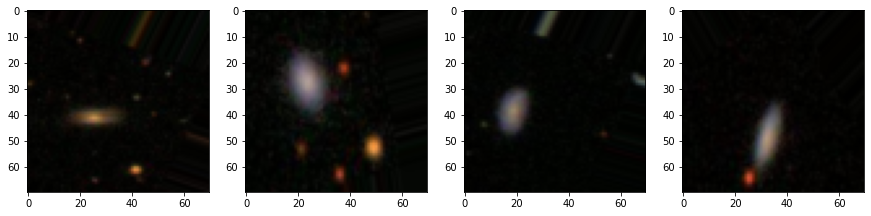

In [ ]:
xc,yc = next(train_crops)
f, axarr = plt.subplots(1,4, figsize=(15, 15))
axarr[0].imshow(xc[0])
axarr[1].imshow(xc[1])
axarr[2].imshow(xc[2])
axarr[3].imshow(xc[3])

## 3.Build the model

Defining the metric root mean square error as mentioned in the kaggle challenge. This metric is then going to be used in the training of the models.

In [ ]:
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

### First model

In [ ]:
#This is the structure of the first model
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(100,100,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dense(37,activation='sigmoid'))

#The model is compiled with a loss of mean square error, adamax optimizer and an evaluation metric of root mean square error 
model.compile(loss='mse', optimizer='adamax', metrics=[rmse])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)        

### Second model

In [ ]:
#This is the structure of the second model
model2 = Sequential()
model2.add(Conv2D(32,(3,3),activation='relu',input_shape=(70,70,3)))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(128,(3,3),activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(128,(3,3),activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(512,activation='relu'))
model2.add(Dense(37,activation='sigmoid'))

#The model is compiled with a loss of mean square error, adamax optimizer and an evaluation metric of root mean square error 
model2.compile(loss='mse', optimizer='adamax', metrics=[rmse])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 128)        

## Third model

In [ ]:
#This is the structure of the second model
model3 = Sequential()
model3.add(Conv2D(32,(3,3),activation='relu',input_shape=(70,70,3)))
model3.add(MaxPooling2D((2,2)))
model3.add(Conv2D(96,(3,3),activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2,2)))
model3.add(Conv2D(128,(3,3),activation='relu'))
model3.add(MaxPooling2D((2,2)))
model3.add(Conv2D(128,(3,3),activation='relu'))
model3.add(MaxPooling2D((2,2)))
model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(96,activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(64,activation='relu'))
model3.add(Dense(37,activation='sigmoid'))

#The model is compiled with a loss of mean square error, adamax optimizer and an evaluation metric of root mean square error 
model3.compile(loss='mse', optimizer='adamax', metrics=[rmse])
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        27744     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       110720    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0

## 4.Train the network and test

In the following cells, I am going to train the models and evaluate them.

### Network 1

In [ ]:
#Here we define some parameters that the model needs to be trained
train_steps = train_generator.n//train_generator.batch_size
val_steps = validation_generator.n//validation_generator.batch_size

#3 hours of training
history = model.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=20, 
                              validation_data=validation_generator,validation_steps=val_steps)

#Save the model and the training history to access in different work sessions
model.save(PATHGZ+'model1.h5')
np.save(PATHGZ+'my_history1.npy',history.history)

Epoch 1/20
80/80 [==============================] - 7436s 93s/step - loss: 0.0382 - rmse: 0.1900 - val_loss: 0.0274 - val_rmse: 0.1655
Epoch 2/20
80/80 [==============================] - 177s 2s/step - loss: 0.0270 - rmse: 0.1642 - val_loss: 0.0269 - val_rmse: 0.1638
Epoch 3/20
80/80 [==============================] - 177s 2s/step - loss: 0.0262 - rmse: 0.1619 - val_loss: 0.0258 - val_rmse: 0.1607
Epoch 4/20
80/80 [==============================] - 176s 2s/step - loss: 0.0250 - rmse: 0.1579 - val_loss: 0.0243 - val_rmse: 0.1559
Epoch 5/20
80/80 [==============================] - 175s 2s/step - loss: 0.0242 - rmse: 0.1554 - val_loss: 0.0235 - val_rmse: 0.1532
Epoch 6/20
80/80 [==============================] - 174s 2s/step - loss: 0.0238 - rmse: 0.1543 - val_loss: 0.0235 - val_rmse: 0.1531
Epoch 7/20
80/80 [==============================] - 174s 2s/step - loss: 0.0234 - rmse: 0.1529 - val_loss: 0.0229 - val_rmse: 0.1513
Epoch 8/20
80/80 [==============================] - 176s 2s/step - 

Load the saved history

The files are in the same directory as the model

In [ ]:
#Load the history file, it is going to be used to create the graphics
history1_saved=np.load(PATHGZ+'my_history1.npy',allow_pickle='TRUE').item()

dict_keys(['loss', 'rmse', 'val_loss', 'val_rmse'])


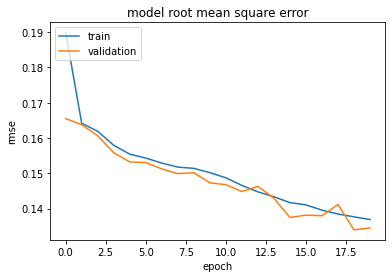

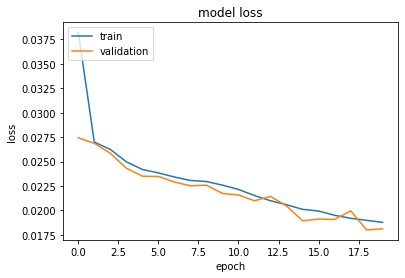

In [ ]:
##PLOT
# list all data in history
print(history1_saved.keys())
# summarize history for rmse
plt.plot(history1_saved['rmse'])
plt.plot(history1_saved['val_rmse'])
plt.title('model root mean square error')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1_saved['loss'])
plt.plot(history1_saved['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Testing of the model

The files are in the same directory as the notebook


In [ ]:
#Load the model file, as it was created in one session and used in other
filepath = PATHGZ+'model1.h5'
model1 = load_model(filepath, compile = True, custom_objects={"rmse": rmse}) #To load the model we have to specify the metric as it was custom made

In the following cell a test generator is created for the purpose of testing the trained model with the test data, so it accesses the test path.

In [ ]:
#These are the generators that I am going to use to predict the test data
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
test_generator = test_datagen.flow_from_directory(test_path,target_size=(100,100),
                                                 shuffle=False,
                                                 class_mode=None,
                                                 batch_size=1,
                                                 seed=7)

Found 2000 images belonging to 1 classes.


#### Prediction

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()  #The test_generator needs to be reset before calling the predict_generator. 
                        #This is important, if it isn't reset the test_generator you will get outputs in a weird order.
prediction=model1.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1) #In this variable we save the predictions made for the test data

2000/2000 [==============================] - 1572s 786ms/step


As it can be seen in the following cell, the root mean square error of the test prediction is 0.1365

In [ ]:
y_true = df_test.iloc[:,1:].to_numpy()
err = rmse(y_true, prediction) #This is the evaluation error
print(err)  

tf.Tensor(0.13641142717586907, shape=(), dtype=float64)


### Network 2

In [ ]:
#Here we define some parameters that the model needs to be trained
train_steps = train_generator2.n//train_generator2.batch_size
val_steps = validation_generator2.n//validation_generator2.batch_size

#2 hours of training
history2 = model2.fit_generator(train_crops,steps_per_epoch=train_steps, epochs=20, 
                              validation_data=validation_generator2,validation_steps=val_steps)

#Save the model and the training history to access in different work sessions
model2.save(PATHGZ+'model2.h5')
np.save(PATHGZ+'my_history2.npy',history2.history)

Epoch 1/20
80/80 [==============================] - 2313s 29s/step - loss: 0.0433 - rmse: 0.2000 - val_loss: 0.0282 - val_rmse: 0.1677
Epoch 2/20
80/80 [==============================] - 287s 4s/step - loss: 0.0272 - rmse: 0.1650 - val_loss: 0.0266 - val_rmse: 0.1629
Epoch 3/20
80/80 [==============================] - 289s 4s/step - loss: 0.0262 - rmse: 0.1617 - val_loss: 0.0250 - val_rmse: 0.1582
Epoch 4/20
80/80 [==============================] - 295s 4s/step - loss: 0.0247 - rmse: 0.1571 - val_loss: 0.0236 - val_rmse: 0.1535
Epoch 5/20
80/80 [==============================] - 295s 4s/step - loss: 0.0240 - rmse: 0.1549 - val_loss: 0.0237 - val_rmse: 0.1538
Epoch 6/20
80/80 [==============================] - 292s 4s/step - loss: 0.0237 - rmse: 0.1538 - val_loss: 0.0231 - val_rmse: 0.1519
Epoch 7/20
80/80 [==============================] - 294s 4s/step - loss: 0.0234 - rmse: 0.1529 - val_loss: 0.0228 - val_rmse: 0.1509
Epoch 8/20
80/80 [==============================] - 291s 4s/step - 

Load the saved history

The files are in the same directory as the notebook

In [ ]:
#Load the history file, it is going to be used to create the graphics
history2_saved=np.load(PATHGZ+'my_history2.npy',allow_pickle='TRUE').item()

dict_keys(['loss', 'rmse', 'val_loss', 'val_rmse'])


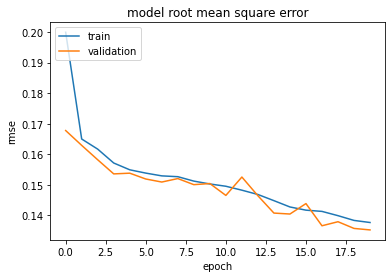

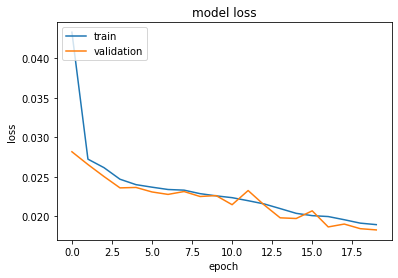

In [ ]:
##PLOT
# list all data in history
print(history2_saved.keys())
# summarize history for rmse
plt.plot(history2_saved['rmse'])
plt.plot(history2_saved['val_rmse'])
plt.title('model root mean square error')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2_saved['loss'])
plt.plot(history2_saved['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Testing of the model

In [ ]:
#Load the model file, as it was created in one session and used in other
filepath = PATHGZ+'model2.h5'
model2 = load_model(filepath, compile = True, custom_objects={"rmse": rmse}) #To load the model we have to specify the metric as it was custom made

In the following cell a test generator is created for the purpose of testing the trained model with the test data, so it accesses the test path.

In [ ]:
#These are the generators that I am going to use to predict the test data

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
test_generator = test_datagen.flow_from_directory(test_path,target_size=(70,70),
                                                 shuffle=False,
                                                 class_mode=None,
                                                 batch_size=1,
                                                 seed=7)


Found 2000 images belonging to 1 classes.


#### Prediction

In [ ]:
#In this cell the prediction for the test data is made
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()  #The test_generator needs to be reset before calling the predict_generator. 
                        #This is important, if it isn't reset the test_generator you will get outputs in a weird order.
prediction=model2.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

2000/2000 [==============================] - 398s 199ms/step


As it can be seen in the following cell, the root mean square error of the test prediction is 0.1365

In [ ]:
y_true = df_test.iloc[:,1:].to_numpy()
err = rmse(y_true, prediction) #This is the evaluation error
print(err)

tf.Tensor(0.1368998987604396, shape=(), dtype=float64)


### Network 3

In [ ]:
train_steps = train_generator2.n//train_generator2.batch_size
val_steps = validation_generator2.n//validation_generator2.batch_size

#Training of the model, it takes 3 hours
history3 = model3.fit_generator(train_crops,steps_per_epoch=train_steps, epochs=20, 
                              validation_data=validation_generator2,validation_steps=val_steps)


#Save the model and the training history to access in different work sessions
model3.save(PATHGZ+'model3.h5')
np.save(PATHGZ+'my_history3.npy',history3.history)

Epoch 1/20
80/80 [==============================] - 551s 7s/step - loss: 0.0678 - rmse: 0.2494 - val_loss: 0.1322 - val_rmse: 0.3636
Epoch 2/20
80/80 [==============================] - 317s 4s/step - loss: 0.0313 - rmse: 0.1768 - val_loss: 0.1045 - val_rmse: 0.3232
Epoch 3/20
80/80 [==============================] - 317s 4s/step - loss: 0.0291 - rmse: 0.1703 - val_loss: 0.0891 - val_rmse: 0.2984
Epoch 4/20
80/80 [==============================] - 320s 4s/step - loss: 0.0276 - rmse: 0.1661 - val_loss: 0.0748 - val_rmse: 0.2734
Epoch 5/20
80/80 [==============================] - 318s 4s/step - loss: 0.0264 - rmse: 0.1622 - val_loss: 0.0580 - val_rmse: 0.2408
Epoch 6/20
80/80 [==============================] - 319s 4s/step - loss: 0.0254 - rmse: 0.1593 - val_loss: 0.0412 - val_rmse: 0.2030
Epoch 7/20
80/80 [==============================] - 317s 4s/step - loss: 0.0245 - rmse: 0.1565 - val_loss: 0.0288 - val_rmse: 0.1696
Epoch 8/20
80/80 [==============================] - 319s 4s/step - lo

Load the saved history

The files are in the same directory as the notebook


In [ ]:
#Load the history file, it is going to be used to create the graphics
history3_saved=np.load(PATHGZ+'my_history3.npy',allow_pickle='TRUE').item()

dict_keys(['loss', 'rmse', 'val_loss', 'val_rmse'])


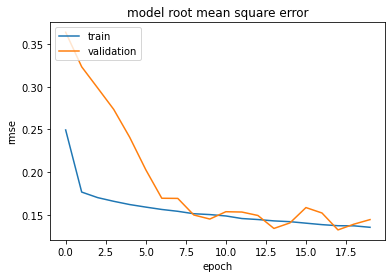

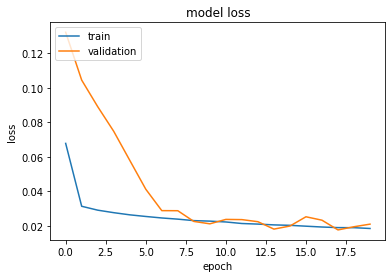

In [ ]:
##PLOT
# list all data in history
print(history3_saved.keys())
# summarize history for rmse
plt.plot(history3_saved['rmse'])
plt.plot(history3_saved['val_rmse'])
plt.title('model root mean square error')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3_saved['loss'])
plt.plot(history3_saved['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Testing of the model

In [ ]:
#Load the saved model
filepath = PATHGZ+'model3.h5'
model3 = load_model(filepath, compile = True, custom_objects={"rmse": rmse})

In the following cell a test generator is created for the purpose of testing the trained model with the test data, so it accesses the test path.

In [ ]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
test_generator = test_datagen.flow_from_directory(test_path,target_size=(70,70),
                                                 shuffle=False,
                                                 class_mode=None,
                                                 batch_size=1,
                                                 seed=7)


Found 2000 images belonging to 1 classes.


In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
#Prediction of the model for the test data
prediction=model3.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

2000/2000 [==============================] - 19s 9ms/step


As it can be seen in the following output, the test root mean square error value is 0.1464, almost the same as the metric of the validation data in the last epoch of the training

In [ ]:
y_true = df_test.iloc[:,1:].to_numpy()
err = rmse(y_true, prediction)
print(err)  

tf.Tensor(0.14643005122659233, shape=(), dtype=float64)


Plot the graphics of the error evolution for each epoch

## 5. Loading pre-trained deep learning models: ResNet50

In the following cell the ResNet model is loaded with the weights of the Imagenet dataset training so that then it will be fine-tuned to use it with the Galaxy Zoo dataset.

In [ ]:
# example of loading the resnet50 model
from keras.applications.resnet50 import ResNet50
# load model
modelResNet = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(70,70,3)))
# summarize the model
modelResNet.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70, 70, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 76, 76, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 35, 35, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 35, 35, 64)   256         conv1_conv[0][0]                 
__________________________

In the following cell more layers are added to the ResNet model.

In [ ]:
myModel = modelResNet.output
myModel = GlobalAveragePooling2D()(myModel)
myModel = Flatten(name="flatten")(myModel)
myModel = Dense(256, activation="relu")(myModel)
myModel = Dropout(0.5)(myModel)
myModel = Dense(37, activation="sigmoid")(myModel)

myResNet = Model(inputs=modelResNet.input, outputs=myModel)
myResNet.compile(loss='mse', optimizer='adamax', metrics=[rmse])

### Train the ResNet

In [ ]:
train_steps = train_generator2.n//train_generator2.batch_size
val_steps = validation_generator2.n//validation_generator2.batch_size

#7 hours of training
historyResNet = myResNet.fit_generator(train_crops,steps_per_epoch=train_steps, epochs=20, 
                              validation_data=validation_generator2,validation_steps=val_steps)

#Save the model and the training history to access in different work sessions
myResNet.save(PATHGZ+'modelResNet.h5')
np.save(PATHGZ+'my_historyResNet.npy',historyResNet.history)

Epoch 1/20
80/80 [==============================] - 2491s 31s/step - loss: 0.0383 - rmse: 0.1897 - val_loss: 0.0306 - val_rmse: 0.1748
Epoch 2/20
80/80 [==============================] - 1173s 15s/step - loss: 0.0231 - rmse: 0.1521 - val_loss: 0.0298 - val_rmse: 0.1726
Epoch 3/20
80/80 [==============================] - 1170s 15s/step - loss: 0.0204 - rmse: 0.1427 - val_loss: 0.0322 - val_rmse: 0.1794
Epoch 4/20
80/80 [==============================] - 1176s 15s/step - loss: 0.0188 - rmse: 0.1369 - val_loss: 0.0343 - val_rmse: 0.1850
Epoch 5/20
80/80 [==============================] - 1166s 15s/step - loss: 0.0177 - rmse: 0.1328 - val_loss: 0.0338 - val_rmse: 0.1837
Epoch 6/20
80/80 [==============================] - 1173s 15s/step - loss: 0.0167 - rmse: 0.1293 - val_loss: 0.0347 - val_rmse: 0.1861
Epoch 7/20
80/80 [==============================] - 1169s 15s/step - loss: 0.0160 - rmse: 0.1262 - val_loss: 0.0334 - val_rmse: 0.1826
Epoch 8/20
80/80 [==============================] - 116

### Loading the history of the training to make graphics

The files are in the same directory as the model

In [2]:
historyRes_saved=np.load(PATHGZ+'my_historyResNet.npy',allow_pickle='TRUE').item()
print(historyRes_saved.keys())

dict_keys(['loss', 'rmse', 'val_loss', 'val_rmse'])


dict_keys(['loss', 'rmse', 'val_loss', 'val_rmse'])


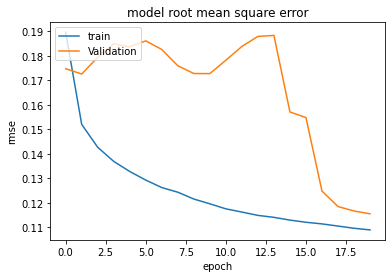

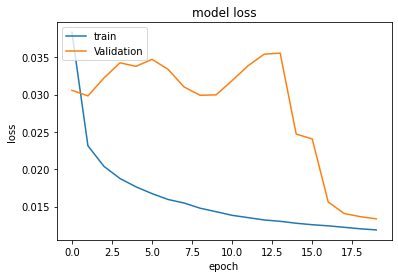

In [3]:
##PLOT
# list all data in history
print(historyRes_saved.keys())
# summarize history for rmse
plt.plot(historyRes_saved['rmse'])
plt.plot(historyRes_saved['val_rmse'])
plt.title('model root mean square error')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyRes_saved['loss'])
plt.plot(historyRes_saved['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

As you can see in these graphs, the difference between the training error and the validation error was too high at first, but it underwent a considerable dropping from the 13th or 14th epoch on.

### Testing of the model on the test data

The files are in the same directory as the model

In [ ]:
#Load the saved model
filepath = PATHGZ+'modelResNet.h5'
modelResNet = load_model(filepath, compile = True, custom_objects={"rmse": rmse})

In [ ]:
#Creation of the test generator to make a prediction on the test data
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
test_generator = test_datagen.flow_from_directory(test_path,target_size=(70,70),
                                                 shuffle=False,
                                                 class_mode=None,
                                                 batch_size=1,
                                                 seed=7)


Found 2000 images belonging to 1 classes.


In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
prediction=modelResNet.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1) #This is the prediction of the test data

Instructions for updating:
Please use Model.predict, which supports generators.
2000/2000 [==============================] - 647s 324ms/step


In the following output, we can see that the prediction error for the test data is 0.1161, which is very close to the validation error in the last epoch of the training of the model. This shows that the best model of this project is this one, as the error was the lowest of them all.

In [ ]:
y_true = df_test.iloc[:,1:].to_numpy()
err = rmse(y_true, prediction)
print(err)

tf.Tensor(0.11611107960574617, shape=(), dtype=float64)
